In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# Cross-Validation and Bias-Variance decomposition
## Cross-Validation
Implementing 4-fold cross-validation below:

In [2]:
from helpers import load_data

# load dataset
x, y = load_data()

In [3]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval] for k in range(k_fold)]
    return np.array(k_indices)

In [4]:
from costs import compute_mse
from ridge_regression import ridge_regression
from build_polynomial import build_poly

def cross_validation(y, x, k_indices, k, lambda_, degree):
    """return the loss of ridge regression."""
    test_tx=x[k_indices[k]]
    test_y=y[k_indices[k]]
    train_tx = np.array([])
    train_y = np.array([])
    for i in range(len(k_indices)):
        if i!=k:
            train_tx = np.concatenate([train_tx, x[k_indices[i]]])
            train_y = np.concatenate([train_y, y[k_indices[i]]])

    test_tx=build_poly(test_tx, degree)
    train_tx=build_poly(train_tx, degree)
    
    w, loss_tr = ridge_regression(train_y, train_tx, lambda_)
    
    loss_te=compute_mse(test_y, test_tx, w)
    
    return w, loss_tr, loss_te

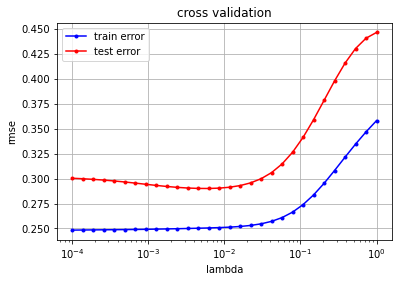

In [5]:
from plots import cross_validation_visualization

def cross_validation_demo():
    seed = 1
    degree = 7
    k_fold = 4
    lambdas = np.logspace(-4, 0, 30)
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    # define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []

    for lambda_ in lambdas:
        loss_tr=0
        loss_te=0
        for k in range(k_fold):
            w, loss_tr_k, loss_te_k = cross_validation(y, x, k_indices, k, lambda_, degree)
            loss_tr=loss_tr+loss_tr_k
            loss_te=loss_te+loss_te_k
        loss_tr=loss_tr/k_fold
        loss_te=loss_te/k_fold
        rmse_tr.append(np.sqrt(2*loss_tr))
        rmse_te.append(np.sqrt(2*loss_te))
    cross_validation_visualization(lambdas, rmse_tr, rmse_te)

cross_validation_demo()

In [6]:
def best_degree_selection(degrees, k_fold, lambdas, seed=1):
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    
    best_lambdas=[]
    best_rmses=[]
    
    for degree in degrees:
        rmse_te = []
        for lambda_ in lambdas:
            rmse_te_tmp=[]
            for k in range(k_fold):
                _, _, loss_te = cross_validation(y, x, k_indices, k, lambda_, degree)
                rmse_te_tmp.append(loss_te)
            rmse_te.append(np.mean(rmse_te_tmp))
        ind_lambda_opt=np.argmin(rmse_te)
        best_lambdas.append(lambdas[ind_lambda_opt])
        best_rmses.append(rmse_te[ind_lambda_opt])
    ind_best_degree=np.argmin(best_rmses)
    
    return degrees[ind_best_degree]

best_degree_selection(np.arange(2,11), 4, np.logspace(-4,0,30))

7

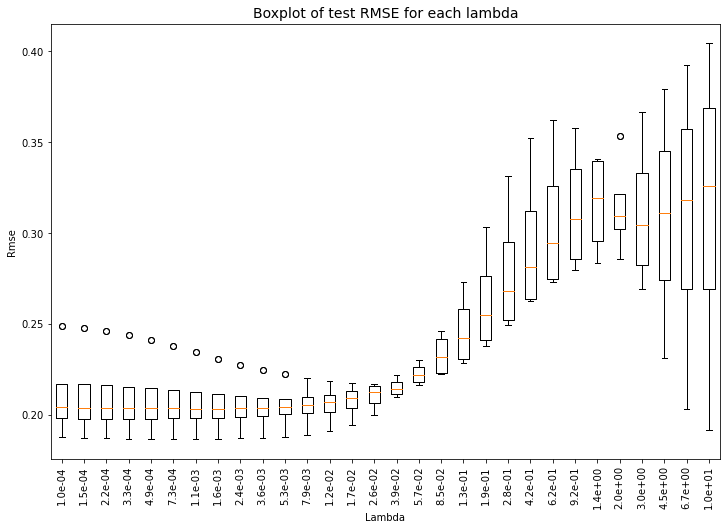

In [7]:
from plots import cross_validation_visualization

def extended_cross_validation_demo():
    seed = 1
    degree = 7
    k_fold = 4
    lambdas = np.logspace(-4, 1, 30)
    
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    
    # define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []
    variances = []

    for idx_lambd, lambda_ in enumerate(lambdas):
        rmse_tr_tmp=[]
        rmse_te_tmp=[]
        for k in range(k_fold):
            _, loss_tr, loss_te = cross_validation(y, x, k_indices, k, lambda_, degree)
            rmse_tr_tmp.append(loss_tr)
            rmse_te_tmp.append(loss_te)
        rmse_tr.append(np.sqrt(2*rmse_tr_tmp))
        rmse_te.append(np.sqrt(2*rmse_te_tmp))
        
    fig, ax = plt.subplots(figsize=(12,8))
    ax.boxplot(rmse_te, notch=None, vert=None, patch_artist=None, widths=None)
    ax.set_xlabel("Lambda")
    ax.set_ylabel("Rmse")
    ax.set_title("Boxplot of test RMSE for each lambda", fontsize=14)
    labels = [item.get_text() for item in ax.get_xticklabels()]
    lambdas= tuple(np.apply_along_axis(lambda y: [str("{:.1e}".format(i)) for i in y], 0, lambdas))
    for idx in range(len(labels)):
        labels[idx] = lambdas[idx]
    ax.set_xticklabels(labels, rotation=90)


extended_cross_validation_demo()

## Bias-Variance Decomposition
Visualize bias-variance trade-off by implementing the function `bias_variance_demo()` below:

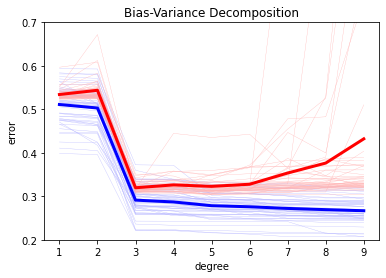

In [8]:
from least_squares import least_squares
from split_data import split_data
from plots import bias_variance_decomposition_visualization

def bias_variance_demo():
    """The entry."""
    # define parameters
    seeds = range(50)
    num_data = 10000
    ratio_train = 0.005
    degrees = range(1, 10)
    
    # define list to store the variable
    rmse_tr = np.empty((len(seeds), len(degrees)))
    rmse_te = np.empty((len(seeds), len(degrees)))
    
    for index_seed, seed in enumerate(seeds):
        np.random.seed(seed)
        x = np.linspace(0.1, 2 * np.pi, num_data)
        y = np.sin(x) + 0.3 * np.random.randn(num_data).T
        train_tx,train_y,test_tx,test_y=split_data(x, y, ratio_train, seed)
        for index_degree, degree in enumerate(degrees):
            test_tx_=build_poly(test_tx, degree)
            train_tx_=build_poly(train_tx, degree)
            w, loss_tr = least_squares(train_y, train_tx_)
            loss_te=compute_mse(test_y, test_tx_, w)
            rmse_tr[index_seed,index_degree]=np.sqrt(2*loss_tr)
            rmse_te[index_seed,index_degree]=np.sqrt(2*loss_te)

    bias_variance_decomposition_visualization(degrees, rmse_tr, rmse_te)
    
    return rmse_te

rmse_te=bias_variance_demo()

Look at the variance of test errors. Does it increase with the degree of polynomial?
- Yes it does (the red line), as expected

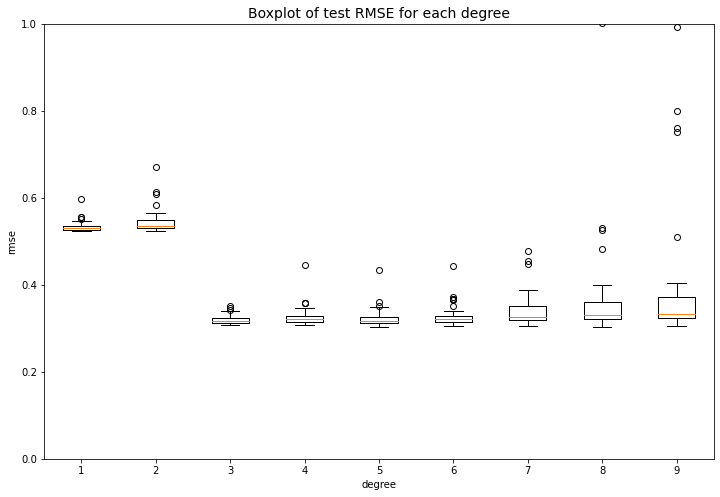

In [9]:
from least_squares import least_squares
from split_data import split_data
from plots import bias_variance_decomposition_visualization

def boxplot_bias_variance_demo(rmse_te):
    degrees = range(1, 10)
    fig, ax = plt.subplots(figsize=(12,8))
    ax.boxplot(rmse_te, notch=None, vert=None, patch_artist=None, widths=None)
    ax.set_xlabel("degree")
    ax.set_ylabel("rmse")
    ax.set_title("Boxplot of test RMSE for each degree", fontsize=14)
    labels = [item.get_text() for item in ax.get_xticklabels()]
    degrees = tuple(np.apply_along_axis(lambda y: [str(i) for i in y], 0, degrees))
    for idx in range(len(labels)):
        labels[idx] = degrees[idx]
    ax.set_xticklabels(labels)
    ax.set_ylim([0,1])

boxplot_bias_variance_demo(rmse_te)

What would you expect to happen if you replace least-squares with Ridge regression? Go through the lecture notes to understand that.
- We expect the variance of the error for high degrees to remain almost constant

In [10]:
def best_lambda_selection(y, x, degree, lambdas, k_fold=4, seed=1):
    
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)

    mse_te = []
    mse_tr = []
    for lambda_ in lambdas:
        mse_te_tmp=[]
        mse_tr_tmp=[]
        for k in range(k_fold):
            _, loss_tr, loss_te = cross_validation(y, x, k_indices, k, lambda_, degree)
            mse_tr_tmp.append(loss_tr)
            mse_te_tmp.append(loss_te)
        mse_tr.append(np.mean(mse_tr_tmp))
        mse_te.append(np.mean(mse_te_tmp))
    ind_lambda_opt=np.argmin(mse_te)
    best_lambda=lambdas[ind_lambda_opt]
    best_loss_te=mse_te[ind_lambda_opt]
    best_loss_tr=mse_tr[ind_lambda_opt]
    
    return best_lambda, best_loss_te, best_loss_tr

In [11]:
def ridge_test_error(y,x,deg):
    seed = 1
    k_fold = 4
    lambdas = np.logspace(-4, 1, 30)
    
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    
    _,mse_te, mse_tr = best_lambda_selection(y, x, deg,lambdas)
                
    return mse_te, mse_tr

In [12]:
from split_data import split_data
from plots import bias_variance_decomposition_visualization
from costs import compute_mse
from build_polynomial import build_poly

def bias_variance_demo_ridge():
    """The entry."""
    # define parameters
    seeds = range(50)
    num_data = 10000
    ratio_train = 0.005
    degrees = range(1, 10)
    
    # define list to store the variable
    rmse_tr = np.empty((len(seeds), len(degrees)))
    rmse_te = np.empty((len(seeds), len(degrees)))
    
    for index_seed, seed in enumerate(seeds):
        np.random.seed(seed)
        x = np.linspace(0.1, 2 * np.pi, num_data)
        y = np.sin(x) + 0.3 * np.random.randn(num_data).T
        train_tx,train_y,test_tx,test_y=split_data(x, y, ratio_train, seed)
        for index_degree, degree in enumerate(degrees):
            test_tx_=build_poly(test_tx, degree)
            rmse_te_, rmse_tr_ = ridge_test_error(train_y,train_tx,degree)
            rmse_tr[index_seed,index_degree]=np.sqrt(2*rmse_tr_)
            rmse_te[index_seed,index_degree]=np.sqrt(2*rmse_te_)
            
    bias_variance_decomposition_visualization(degrees, rmse_tr, rmse_te)
    
    return rmse_te

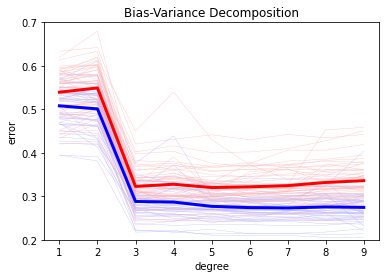

In [13]:
rmse_te=bias_variance_demo_ridge()

In [14]:
from split_data import split_data
from plots import bias_variance_decomposition_visualization
from costs import compute_mse
from build_polynomial import build_poly

def boxplot_bias_variance_demo_ridge(rmse_te): 
    degrees = range(1, 10)
    fig, ax = plt.subplots(figsize=(12,8))
    ax.boxplot(rmse_te, notch=None, vert=None, patch_artist=None, widths=None)
    ax.set_xlabel("degree")
    ax.set_ylabel("rmse")
    ax.set_title("Boxplot of test RMSE for each degree", fontsize=14)
    labels = [item.get_text() for item in ax.get_xticklabels()]
    degrees = tuple(np.apply_along_axis(lambda y: [str(i) for i in y], 0, degrees))
    for idx in range(len(labels)):
        labels[idx] = degrees[idx]
    ax.set_xticklabels(labels)
    ax.set_ylim([0,1])

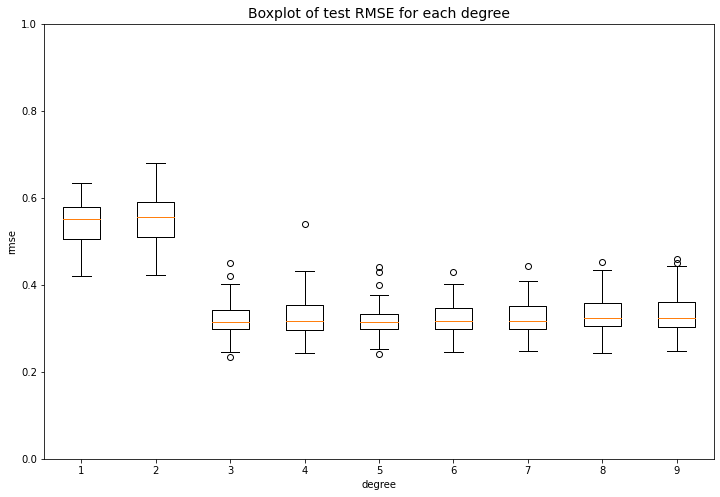

In [15]:
boxplot_bias_variance_demo_ridge(rmse_te)